In [ ]:

!pip install --upgrade bias_detector


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bias_detector.BiasDetector import *
from sklearn.metrics import roc_curve, auc, roc_auc_score


In [3]:

df = pd.read_csv('2000-present/congress_members.csv', index_col=0, keep_default_na=False)


In [4]:

df['race'].loc[df['race'] == ''] = 'unknown'


In [5]:

df.head()


,full_name,last_name,first_name,race,gender
0,"ABERCROMBIE, Neil",abercrombie,neil,unknown,male
1,"ABRAHAM, Ralph",abraham,ralph,unknown,male
2,"ACEVEDO-VILA, Anibal",acevedovila,anibal,hispanic,male
3,"ACKERMAN, Gary Leonard",ackerman,gary,unknown,male
4,"ADAMS, Alma",adams,alma,black,female


In [6]:

len(df)


1190

In [7]:

df['gender'].value_counts(normalize=False)


male      958
female    232
Name: gender, dtype: int64

In [8]:

df['gender'].value_counts(normalize=True)


male      0.805042
female    0.194958
Name: gender, dtype: float64

In [9]:

df['race'].value_counts(normalize=False)


unknown     988
black        96
hispanic     76
api          30
Name: race, dtype: int64

In [10]:

df['race'].value_counts(normalize=True)


unknown     0.830252
black       0.080672
hispanic    0.063866
api         0.025210
Name: race, dtype: float64

In [11]:

df_demographic_breakdown = df.reset_index()[['index', 'gender', 'race']].pivot_table(index='gender', columns='race', values='index', aggfunc='count')
df_demographic_breakdown


race,api,black,hispanic,unknown
gender,,,,
female,13,41,21,157
male,17,55,55,831


In [12]:

df_demographic_breakdown['total'] = df_demographic_breakdown.sum(axis=1)
df_demographic_breakdown.loc['total'] = df_demographic_breakdown.sum(axis=0)
df_demographic_breakdown


race,api,black,hispanic,unknown,total
gender,,,,,
female,13,41,21,157,232
male,17,55,55,831,958
total,30,96,76,988,1190


In [13]:

gender_p_groups = BiasDetector().get_p_groups(first_names = df['first_name'], last_names = df['last_name'])[['male', 'female']]
gender_df = pd.concat([df[['gender', 'race']], gender_p_groups], axis=1)
gender_supported_mask = (gender_p_groups['male'] > 0) | (gender_p_groups['female'] > 0)
gender_df = gender_df.loc[gender_supported_mask].reset_index(drop=True)


In [14]:

gender_df.head()


,gender,race,male,female
0,male,unknown,1.000000,0.000000
1,male,unknown,1.000000,0.000000
2,male,hispanic,1.000000,0.000000
3,male,unknown,0.996933,0.003067
4,female,black,0.000000,1.000000


<AxesSubplot:title={'center':'p_female for female group'}, ylabel='Frequency'>

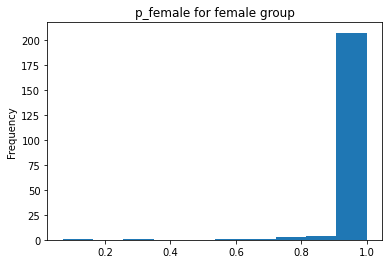

In [15]:

data = gender_df.loc[gender_df['gender'] == 'female']['female']
data.plot(kind='hist',title='p_female for female group')


<AxesSubplot:title={'center':'p_male for female group'}, ylabel='Frequency'>

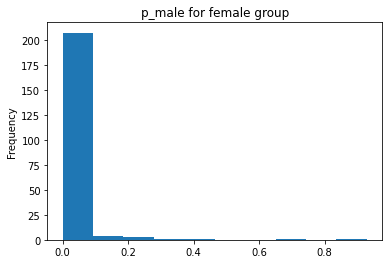

In [16]:

data = gender_df.loc[gender_df['gender'] == 'female']['male']
data.plot(kind='hist',title='p_male for female group')


<AxesSubplot:title={'center':'p_male for Male group'}, ylabel='Frequency'>

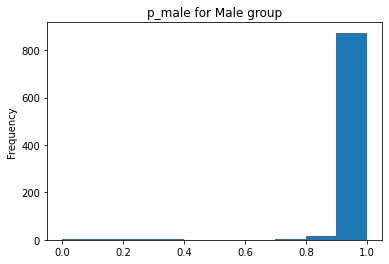

In [17]:

data = gender_df.loc[gender_df['gender'] == 'male']['male']
data.plot(kind='hist',title='p_male for Male group')


<AxesSubplot:title={'center':'p_female for male group'}, ylabel='Frequency'>

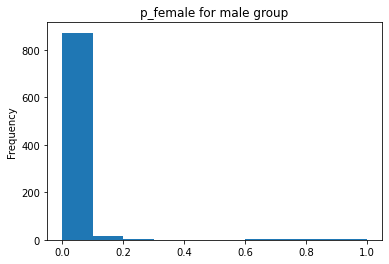

In [18]:

data = gender_df.loc[gender_df['gender'] == 'male']['female']
data.plot(kind='hist',title='p_female for male group')


In [19]:

from bias_detector.common import races

races


['white', 'black', 'api', 'hispanic', 'native']

In [20]:

def get_races_supported_mask(df):
    return (df['white'] > 0) | (df['black'] > 0) | (df['api'] > 0) | (df['hispanic'] > 0) | (df['native'] > 0)

first_name_p_race = BiasDetector().get_p_groups(first_names = df['first_name'])[races]
last_name_p_race = BiasDetector().get_p_groups(last_names = df['last_name'])[races]
full_name_p_race = BiasDetector().get_p_groups(first_names = df['first_name'], last_names = df['last_name'])[races]

races_supported_mask = get_races_supported_mask(first_name_p_race) & get_races_supported_mask(last_name_p_race) & get_races_supported_mask(full_name_p_race)

first_name_race_df = pd.concat([df[['race']], first_name_p_race], axis=1).loc[races_supported_mask].reset_index(drop=True)
last_name_race_df = pd.concat([df[['race']], last_name_p_race], axis=1).loc[races_supported_mask].reset_index(drop=True)
full_name_race_df = pd.concat([df[['race']], full_name_p_race], axis=1).loc[races_supported_mask].reset_index(drop=True)


Text(0, 0.5, 'Frequency')

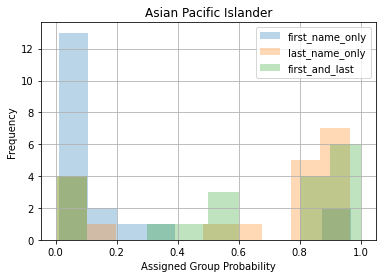

In [21]:

data_first = first_name_race_df.loc[first_name_race_df['race'] == 'api']['api']
data_last = last_name_race_df.loc[last_name_race_df['race'] == 'api']['api']
data_first_last = full_name_race_df.loc[full_name_race_df['race'] == 'api']['api']

df1 = pd.DataFrame({
    'first_name_only': data_first,
    'last_name_only': data_last,
    'first_and_last': data_first_last
})

fig, ax = plt.subplots()
df1.hist(column=['first_name_only'], ax=ax, alpha=0.3)
df1.hist(column=['last_name_only'], ax=ax, alpha=0.3)
df1.hist(column=['first_and_last'], ax=ax, alpha=0.3)
ax.set_title("Asian Pacific Islander")
ax.legend(df1.columns)
ax.set_xlabel("Assigned Group Probability")
ax.set_ylabel("Frequency")


Text(0, 0.5, 'Frequency')

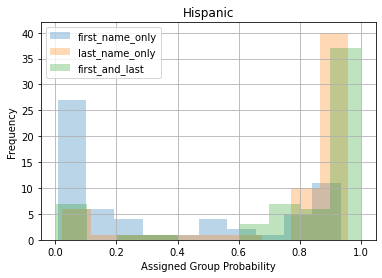

In [22]:

data_first = first_name_race_df.loc[first_name_race_df['race'] == 'hispanic']['hispanic']
data_last = last_name_race_df.loc[last_name_race_df['race'] == 'hispanic']['hispanic']
data_first_last = full_name_race_df.loc[full_name_race_df['race'] == 'hispanic']['hispanic']

df1 = pd.DataFrame({
    'first_name_only': data_first,
    'last_name_only': data_last,
    'first_and_last': data_first_last
})

fig, ax = plt.subplots()
df1.hist(column=['first_name_only'], ax=ax, alpha=0.3)
df1.hist(column=['last_name_only'], ax=ax, alpha=0.3)
df1.hist(column=['first_and_last'], ax=ax, alpha=0.3)
ax.set_title("Hispanic")
ax.legend(df1.columns)
ax.set_xlabel("Assigned Group Probability")
ax.set_ylabel("Frequency")


Text(0, 0.5, 'Frequency')

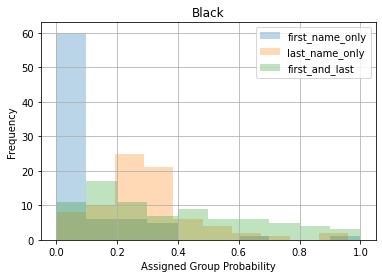

In [23]:

data_first = first_name_race_df.loc[first_name_race_df['race'] == 'black']['black']
data_last = last_name_race_df.loc[last_name_race_df['race'] == 'black']['black']
data_first_last = full_name_race_df.loc[full_name_race_df['race'] == 'black']['black']

df1 = pd.DataFrame({
    'first_name_only': data_first,
    'last_name_only': data_last,
    'first_and_last': data_first_last
})

fig, ax = plt.subplots()
df1.hist(column=['first_name_only'], ax=ax, alpha=0.3)
df1.hist(column=['last_name_only'], ax=ax, alpha=0.3)
df1.hist(column=['first_and_last'], ax=ax, alpha=0.3)
ax.set_title("Black")
ax.legend(df1.columns)
ax.set_xlabel("Assigned Group Probability")
ax.set_ylabel("Frequency")


In [24]:

gender_df_female = gender_df.replace({'female': 1, 'male': 0})
gender_df_male = gender_df.replace({'female': 0, 'male': 1})


In [25]:

fpr_female, tpr_female, thresholds_female = roc_curve(gender_df_female['gender'], gender_df_female['female'])
roc_female = roc_auc_score(gender_df_female['gender'], gender_df_female['female'])


In [26]:

fpr_male, tpr_male, thresholds_male = roc_curve(gender_df_male['gender'], gender_df_male['male'])
roc_male = roc_auc_score(gender_df_male['gender'], gender_df_male['male'])


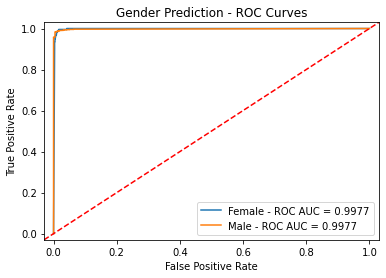

In [27]:

fig, ax = plt.subplots()
plt.plot(fpr_female, tpr_female)
plt.plot(fpr_male, tpr_male)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title("Gender Prediction - ROC Curves")
plt.plot([-0.03,1.03],[-0.03,1.03],'r--')
plt.xlim([-0.03,1.03])
plt.ylim([-0.03,1.03])
ax.legend(['Female - ROC AUC = ' + str(round(roc_female,4)), 'Male - ROC AUC = ' + str(round(roc_male,4))])


In [28]:

race_df_black = full_name_race_df.replace({'black': 1, 'hispanic': 0, 'api': 0, 'unknown':0})
race_df_hispanic = full_name_race_df.replace({'black': 0, 'hispanic': 1, 'api': 0, 'unknown':0})
race_df_api = full_name_race_df.replace({'black': 0, 'hispanic': 0, 'api': 1, 'unknown':0})


In [29]:

fpr_black, tpr_black, thresholds_black = roc_curve(race_df_black['race'], race_df_black['black'])
roc_black = roc_auc_score(race_df_black['race'], race_df_black['black'])


In [30]:

fpr_hispanic, tpr_hispanic, thresholds_hispanic = roc_curve(race_df_hispanic['race'], race_df_hispanic['hispanic'])
roc_hispanic = roc_auc_score(race_df_hispanic['race'], race_df_hispanic['hispanic'])


In [31]:

fpr_api, tpr_api, thresholds_api = roc_curve(race_df_api['race'], race_df_api['api'])
roc_api = roc_auc_score(race_df_api['race'], race_df_api['api'])


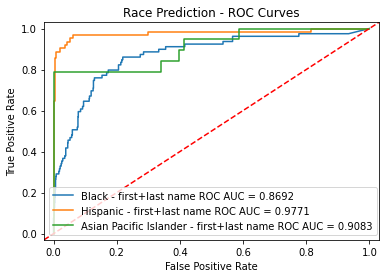

In [32]:

fig, ax = plt.subplots()
plt.plot(fpr_black, tpr_black)
plt.plot(fpr_hispanic, tpr_hispanic)
plt.plot(fpr_api, tpr_api)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title("Race Prediction - ROC Curves")
plt.plot([-0.03,1.03],[-0.03,1.03],'r--')
plt.xlim([-0.03,1.03])
plt.ylim([-0.03,1.03])
ax.legend(['Black - first+last name ROC AUC = ' + str(round(roc_black,4)), 
           'Hispanic - first+last name ROC AUC = ' + str(round(roc_hispanic,4)), 
           'Asian Pacific Islander - first+last name ROC AUC = ' + str(round(roc_api,4)),])


In [33]:

race_df_first_black = first_name_race_df.replace({'black': 1, 'hispanic': 0, 'api': 0, 'unknown':0})
race_df_first_hispanic = first_name_race_df.replace({'black': 0, 'hispanic': 1, 'api': 0, 'unknown':0})
race_df_first_api = first_name_race_df.replace({'black': 0, 'hispanic': 0, 'api': 1, 'unknown':0})


In [34]:

fpr_black_first, tpr_black_first, thresholds_black_first = roc_curve(race_df_first_black['race'], race_df_first_black['black'])
roc_black_first = roc_auc_score(race_df_first_black['race'], race_df_first_black['black'])


In [35]:

fpr_hispanic_first, tpr_hispanic_first, thresholds_hispanic_first = roc_curve(race_df_first_hispanic['race'], race_df_first_hispanic['hispanic'])
roc_hispanic_first = roc_auc_score(race_df_first_hispanic['race'], race_df_first_hispanic['hispanic'])


In [36]:

fpr_api_first, tpr_api_first, thresholds_api_first = roc_curve(race_df_first_api['race'], race_df_first_api['api'])
roc_api_first = roc_auc_score(race_df_first_api['race'], race_df_first_api['api'])


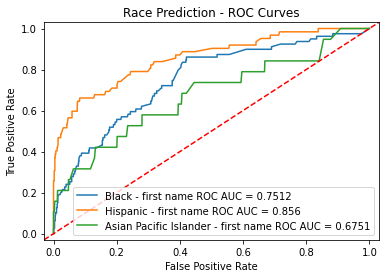

In [37]:

fig, ax = plt.subplots()
plt.plot(fpr_black_first, tpr_black_first)
plt.plot(fpr_hispanic_first, tpr_hispanic_first)
plt.plot(fpr_api_first, tpr_api_first)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title("Race Prediction - ROC Curves")
plt.plot([-0.03,1.03],[-0.03,1.03],'r--')
plt.xlim([-0.03,1.03])
plt.ylim([-0.03,1.03])
ax.legend(['Black - first name ROC AUC = ' + str(round(roc_black_first,4)), 
           'Hispanic - first name ROC AUC = ' + str(round(roc_hispanic_first,4)), 
           'Asian Pacific Islander - first name ROC AUC = ' + str(round(roc_api_first,4)),])


In [38]:

race_df_last_black = last_name_race_df.replace({'black': 1, 'hispanic': 0, 'api': 0, 'unknown':0})
race_df_last_hispanic = last_name_race_df.replace({'black': 0, 'hispanic': 1, 'api': 0, 'unknown':0})
race_df_last_api = last_name_race_df.replace({'black': 0, 'hispanic': 0, 'api': 1, 'unknown':0})


In [39]:

fpr_black_last, tpr_black_last, thresholds_black_last = roc_curve(race_df_last_black['race'], race_df_last_black['black'])
roc_black_last = roc_auc_score(race_df_last_black['race'], race_df_last_black['black'])


In [40]:

fpr_hispanic_last, tpr_hispanic_last, thresholds_hispanic_last = roc_curve(race_df_last_hispanic['race'], race_df_last_hispanic['hispanic'])
roc_hispanic_last = roc_auc_score(race_df_last_hispanic['race'], race_df_last_hispanic['hispanic'])


In [41]:

fpr_api_last, tpr_api_last, thresholds_api_last = roc_curve(race_df_last_api['race'], race_df_last_api['api'])
roc_api_last = roc_auc_score(race_df_last_api['race'], race_df_last_api['api'])


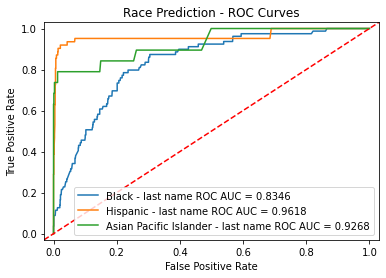

In [42]:

fig, ax = plt.subplots()
plt.plot(fpr_black_last, tpr_black_last)
plt.plot(fpr_hispanic_last, tpr_hispanic_last)
plt.plot(fpr_api_last, tpr_api_last)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title("Race Prediction - ROC Curves")
plt.plot([-0.03,1.03],[-0.03,1.03],'r--')
plt.xlim([-0.03,1.03])
plt.ylim([-0.03,1.03])
ax.legend(['Black - last name ROC AUC = ' + str(round(roc_black_last,4)), 
           'Hispanic - last name ROC AUC = ' + str(round(roc_hispanic_last,4)), 
           'Asian Pacific Islander - last name ROC AUC = ' + str(round(roc_api_last,4)),])


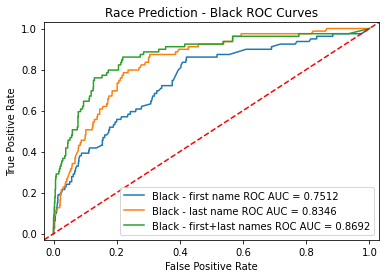

In [43]:

fig, ax = plt.subplots()
plt.plot(fpr_black_first, tpr_black_first)
plt.plot(fpr_black_last, tpr_black_last)
plt.plot(fpr_black, tpr_black)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title("Race Prediction - Black ROC Curves")
plt.plot([-0.03,1.03],[-0.03,1.03],'r--')
plt.xlim([-0.03,1.03])
plt.ylim([-0.03,1.03])
ax.legend(['Black - first name ROC AUC = ' + str(round(roc_black_first,4)), 
           'Black - last name ROC AUC = ' + str(round(roc_black_last,4)), 
           'Black - first+last names ROC AUC = ' + str(round(roc_black,4)),])


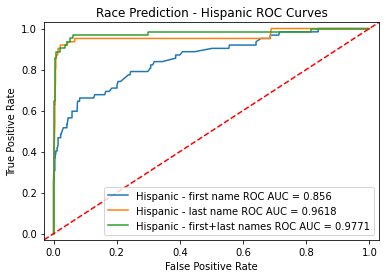

In [44]:

fig, ax = plt.subplots()
plt.plot(fpr_hispanic_first, tpr_hispanic_first)
plt.plot(fpr_hispanic_last, tpr_hispanic_last)
plt.plot(fpr_hispanic, tpr_hispanic)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title("Race Prediction - Hispanic ROC Curves")
plt.plot([-0.03,1.03],[-0.03,1.03],'r--')
plt.xlim([-0.03,1.03])
plt.ylim([-0.03,1.03])
ax.legend(['Hispanic - first name ROC AUC = ' + str(round(roc_hispanic_first,4)), 
           'Hispanic - last name ROC AUC = ' + str(round(roc_hispanic_last,4)), 
           'Hispanic - first+last names ROC AUC = ' + str(round(roc_hispanic,4)),])


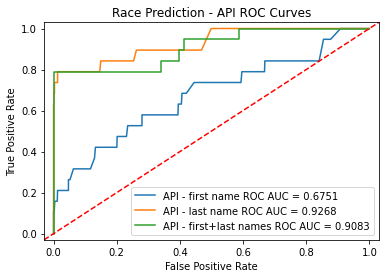

In [45]:

fig, ax = plt.subplots()
plt.plot(fpr_api_first, tpr_api_first)
plt.plot(fpr_api_last, tpr_api_last)
plt.plot(fpr_api, tpr_api)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title("Race Prediction - API ROC Curves")
plt.plot([-0.03,1.03],[-0.03,1.03],'r--')
plt.xlim([-0.03,1.03])
plt.ylim([-0.03,1.03])
ax.legend(['API - first name ROC AUC = ' + str(round(roc_api_first,4)), 
           'API - last name ROC AUC = ' + str(round(roc_api_last,4)), 
           'API - first+last names ROC AUC = ' + str(round(roc_api,4)),])


In [46]:

temp_genders = gender_df['gender'].unique()
temp_races = gender_df['race'].unique()
gender_auc_df = pd.DataFrame(index=temp_races)
for gender in temp_genders:
    for race in temp_races:
        temp_race_df = gender_df.loc[gender_df['race'] == race].reset_index(drop=True)
        temp_y_true = (temp_race_df['gender'] == gender).astype(float).values
        temp_y_scores = temp_race_df[gender]
        temp_auc = roc_auc_score(temp_y_true, temp_y_scores)
        gender_auc_df.at[race, '#' + gender] = np.sum(temp_y_true)
        gender_auc_df.at[race, gender] = temp_auc

for gender in temp_genders:
    gender_auc_df.at['w.a.', gender] = np.sum(gender_auc_df['#' + gender] * gender_auc_df[gender]) / np.sum(gender_auc_df['#' + gender])

print('gender auc\n', gender_auc_df[temp_genders])


gender auc
               male    female
unknown   0.999054  0.999054
hispanic  1.000000  1.000000
black     0.999365  0.999365
api       0.908333  0.908333
w.a.      0.997919  0.995034


In [53]:
temp_genders = gender_df['gender'].unique()
temp_races = gender_df['race'].unique()
gender_corr_df = pd.DataFrame(index=temp_races)
for gender in temp_genders:
    for race in temp_races:
        temp_race_df = gender_df.loc[gender_df['race'] == race].reset_index(drop=True)
        temp_y_true = (temp_race_df['gender'] == gender).astype(float).values
        temp_y_scores = temp_race_df[gender]
        temp_corr = np.corrcoef(temp_y_true, temp_y_scores)[0, 1]
        gender_corr_df.at[race, '#' + gender] = np.sum(temp_y_true)
        gender_corr_df.at[race, gender] = temp_corr

for gender in temp_genders:
    gender_corr_df.at['w.a.', gender] = np.sum(gender_corr_df['#' + gender] * gender_corr_df[gender]) / np.sum(gender_corr_df['#' + gender])

print('gender correlation\n', gender_corr_df[temp_genders])


gender correlation
               male    female
unknown   0.967522  0.967522
hispanic  0.984014  0.984014
black     0.976348  0.976348
api       0.807757  0.807757
w.a.      0.966736  0.963199


In [58]:

temp_races = ['hispanic', 'black', 'api']
data_used_dict = {'first': first_name_race_df, 'last': last_name_race_df, 'full': full_name_race_df}
race_auc_df = pd.DataFrame(index=temp_races)
for race in temp_races:
    for data_used_key in data_used_dict.keys():
        temp_race_df = data_used_dict[data_used_key].reset_index(drop=True)
        temp_y_true = (temp_race_df['race'] == race).astype(float).values
        temp_y_scores = temp_race_df[race]
        temp_auc = roc_auc_score(temp_y_true, temp_y_scores)
        race_auc_df.at[race, '#' + data_used_key] = np.sum(temp_y_true)
        race_auc_df.at[race, data_used_key] = temp_auc

for data_used_key in data_used_dict.keys():
    race_auc_df.at['w.a.', data_used_key] = np.sum(race_auc_df['#' + data_used_key] * race_auc_df[data_used_key]) / np.sum(race_auc_df['#' + data_used_key])

print('race auc\n', race_auc_df[data_used_dict.keys()])


race auc
              first      last      full
hispanic  0.855972  0.961787  0.977089
black     0.751163  0.834591  0.869190
api       0.675137  0.926843  0.908334
w.a.      0.782748  0.894834  0.915649


In [59]:

temp_races = ['hispanic', 'black', 'api']
data_used_dict = {'first': first_name_race_df, 'last': last_name_race_df, 'full': full_name_race_df}
race_corr_df = pd.DataFrame(index=temp_races)
for race in temp_races:
    for data_used_key in data_used_dict.keys():
        temp_race_df = data_used_dict[data_used_key].reset_index(drop=True)
        temp_y_true = (temp_race_df['race'] == race).astype(float).values
        temp_y_scores = temp_race_df[race]
        temp_corr = np.corrcoef(temp_y_true, temp_y_scores)[0, 1]
        race_corr_df.at[race, '#' + data_used_key] = np.sum(temp_y_true)
        race_corr_df.at[race, data_used_key] = temp_corr

for data_used_key in data_used_dict.keys():
    race_corr_df.at['w.a.', data_used_key] = np.sum(race_corr_df['#' + data_used_key] * race_corr_df[data_used_key]) / np.sum(race_corr_df['#' + data_used_key])

print('race correlation\n', race_corr_df[data_used_dict.keys()])


race correlation
              first      last      full
hispanic  0.585065  0.863921  0.879806
black     0.303111  0.376183  0.498852
api       0.267079  0.765134  0.810017
w.a.      0.408089  0.611370  0.683422


In [48]:

gender_supported_mask.value_counts(normalize=True)


True     0.944538
False    0.055462
dtype: float64

In [49]:

gender_supported_mask.value_counts()


True     1124
False      66
dtype: int64

In [50]:

races_supported_mask.value_counts(normalize=True)


True     0.871429
False    0.128571
dtype: float64

In [51]:

races_supported_mask.value_counts()


True     1037
False     153
dtype: int64